In [12]:
import torch
import torchvision
import os

# from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt

In [3]:
batch_size = 100
dataset_size = 55000
validation_size = 5000
test_size = 10000

In [4]:
# Load MNIST training set
train_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=True,
                                         download=True, transform=transforms.ToTensor())

# Split training set into training and validation set
train_data, validation_data = torch.utils.data.random_split(train_data,[dataset_size, validation_size])
# Load MNIST test set
test_data = torchvision.datasets.MNIST(root=os.environ.get("DATASETS_PATH", "~/datasets"), train=False,
                                        download=True, transform=transforms.ToTensor())

# Put datasets into data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=validation_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_size)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(784, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400, 400, bias=True),
                      nn.SELU(),
                      nn.Linear(400,10, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [6]:
class evaluation(object):
    def __init__(self, test_data, criterion):
        self.test_data = test_data
        self.criterion = criterion
        self.n = 0
        self.avg_prediction = 0.

    def acc(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)
                predictions = model(x)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + predictions / self.n
                

                loss = self.criterion(self.avg_prediction, y)
                acc = 100 * (self.avg_prediction.argmax(1) == y).float().sum() / x.shape[0]

        return loss, acc

In [10]:
import sgld


# Model parameter
lambda_ = 1.
lr = 3e-6


network = Model()
criterion = nn.CrossEntropyLoss(size_average=False)
optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
evaluate = evaluation(test_loader, criterion)

t = 1
n = 0

losses_sgld = []
acc_sgld = []

for epoch in range(50):
    running_loss = 0
    for x, y in iter(train_loader):
        x = x.view(x.size(0), -1)

        network.zero_grad()
        output = network(x)
        loss = criterion(output, y)
        loss.backward()
        optim.step()

        running_loss += loss * batch_size / dataset_size
        prediction = output.data.max(1)[1]
        accuracy = torch.sum(prediction.eq(y)).float()/batch_size

    
        if (t >= 300) & (t % 100 == 0):
            loss, acc = evaluate.acc(network)


        t += 1.
        
    losses_sgld.append(loss)
    acc_sgld.append(acc)

    print("Epoch {:d} - loss: {:.4f} - acc: {:.4f}".format(epoch, running_loss, accuracy))
    
error_sgld = [100-x for x in acc_sgld]

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 - loss: 43.8766 - acc: 0.9000
Epoch 1 - loss: 24.6939 - acc: 0.9500
Epoch 2 - loss: 18.3002 - acc: 0.9400
Epoch 3 - loss: 16.2526 - acc: 0.9600
Epoch 4 - loss: 14.9881 - acc: 0.9600
Epoch 5 - loss: 14.2909 - acc: 0.9700
Epoch 6 - loss: 14.3918 - acc: 0.9700
Epoch 7 - loss: 12.9662 - acc: 0.9700
Epoch 8 - loss: 14.5359 - acc: 0.9600
Epoch 9 - loss: 13.3981 - acc: 0.9500
Epoch 10 - loss: 14.0962 - acc: 0.9700
Epoch 11 - loss: 14.8817 - acc: 0.9900
Epoch 12 - loss: 15.2907 - acc: 0.9800
Epoch 13 - loss: 13.9308 - acc: 0.9700
Epoch 14 - loss: 14.9910 - acc: 0.9900
Epoch 15 - loss: 16.5906 - acc: 0.9800
Epoch 16 - loss: 14.6244 - acc: 0.9900
Epoch 17 - loss: 14.3980 - acc: 0.9800
Epoch 18 - loss: 7.3491 - acc: 1.0000
Epoch 19 - loss: 2.6038 - acc: 0.9900
Epoch 20 - loss: 2.2579 - acc: 1.0000
Epoch 21 - loss: 2.7413 - acc: 0.9900
Epoch 22 - loss: 2.7999 - acc: 1.0000
Epoch 23 - loss: 2.5388 - acc: 1.0000
Epoch 24 - loss: 3.3066 - acc: 1.0000
Epoch 25 - loss: 3.2178 - acc: 1.0000
Epoc

(1.2, 2.4)

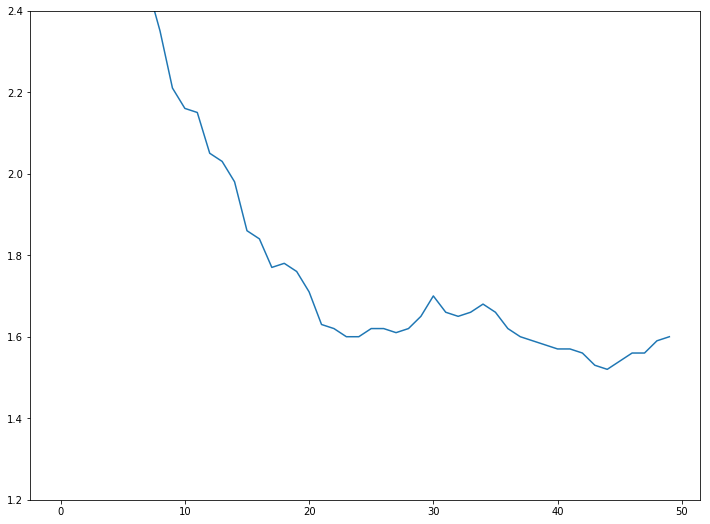

In [34]:
plt.figure(figsize=(12,9))
plt.plot(range(len(acc_sgld)),acc_sgld)
plt.ylim(1.2,2.4)

In [32]:
acc_sgld

[tensor(8.0200),
 tensor(5.2700),
 tensor(3.9000),
 tensor(3.3000),
 tensor(3.0300),
 tensor(2.7400),
 tensor(2.6200),
 tensor(2.4600),
 tensor(2.3500),
 tensor(2.2100),
 tensor(2.1600),
 tensor(2.1500),
 tensor(2.0500),
 tensor(2.0300),
 tensor(1.9800),
 tensor(1.8600),
 tensor(1.8400),
 tensor(1.7700),
 tensor(1.7800),
 tensor(1.7600),
 tensor(1.7100),
 tensor(1.6300),
 tensor(1.6200),
 tensor(1.6000),
 tensor(1.6000),
 tensor(1.6200),
 tensor(1.6200),
 tensor(1.6100),
 tensor(1.6200),
 tensor(1.6500),
 tensor(1.7000),
 tensor(1.6600),
 tensor(1.6500),
 tensor(1.6600),
 tensor(1.6800),
 tensor(1.6600),
 tensor(1.6200),
 tensor(1.6000),
 tensor(1.5900),
 tensor(1.5800),
 tensor(1.5700),
 tensor(1.5700),
 tensor(1.5600),
 tensor(1.5300),
 tensor(1.5200),
 tensor(1.5400),
 tensor(1.5600),
 tensor(1.5600),
 tensor(1.5900),
 tensor(1.6000)]

In [36]:
acc

[tensor(91.9800),
 tensor(94.7300),
 tensor(96.1000),
 tensor(96.7000),
 tensor(96.9700),
 tensor(97.2600),
 tensor(97.3800),
 tensor(97.5400),
 tensor(97.6500),
 tensor(97.7900),
 tensor(97.8400),
 tensor(97.8500),
 tensor(97.9500),
 tensor(97.9700),
 tensor(98.0200),
 tensor(98.1400),
 tensor(98.1600),
 tensor(98.2300),
 tensor(98.2200),
 tensor(98.2400),
 tensor(98.2900),
 tensor(98.3700),
 tensor(98.3800),
 tensor(98.4000),
 tensor(98.4000),
 tensor(98.3800),
 tensor(98.3800),
 tensor(98.3900),
 tensor(98.3800),
 tensor(98.3500),
 tensor(98.3000),
 tensor(98.3400),
 tensor(98.3500),
 tensor(98.3400),
 tensor(98.3200),
 tensor(98.3400),
 tensor(98.3800),
 tensor(98.4000),
 tensor(98.4100),
 tensor(98.4200),
 tensor(98.4300),
 tensor(98.4300),
 tensor(98.4400),
 tensor(98.4700),
 tensor(98.4800),
 tensor(98.4600),
 tensor(98.4400),
 tensor(98.4400),
 tensor(98.4100),
 tensor(98.4000)]